# Tritium release

This example shows how to run a 0D tritium release model.

## Theory

The model is a simple ODE:

$$
V \frac{d c_\mathrm{salt}}{dt} = S - Q_\mathrm{wall} - Q_\mathrm{top}
$$
where $V$ is the volume of the salt, $c_\mathrm{salt}$ is the tritium concentration in the salt, $S$ is the tritium source term, and $Q_i$ are the different release rates.

The source term is expressed as:

$$
S = \mathrm{TBR} \cdot \Gamma_n 
$$
where $\mathrm{TBR}$ is the Tritium Breeding Ratio and $\Gamma_n$ is the neutron rate.

The release rates are expressed as:

$$
Q_i = A_i \ k_i \ (c_\mathrm{salt} - c_\mathrm{external}) \\ \approx A_i \ k_i \ c_\mathrm{salt}
$$
where $A_i$ is the surface area, $k_i$ is the mass transport coefficient, and $c_\mathrm{external}$ is the external tritium concentration (assumed negligible compared to $c_\mathrm{salt}$).

## Implementation

First we import the right module:

In [1]:
from libra_toolbox.tritium import model, ureg

We can then create a model using the `Model` class.

In [2]:
import numpy as np

# geometry
baby_diameter = 1.77 * ureg.inches - 2 * 0.06 * ureg.inches  # from CAD drawings
baby_volume = 0.100 * ureg.L

baby_radius = 0.5 * baby_diameter
baby_cross_section = np.pi * baby_radius**2

baby_height = baby_volume / baby_cross_section

# neutron rate
P383_neutron_rate = 4.95e8 / 2 * ureg.neutron * ureg.s**-1
A325_neutron_rate = 2.13e8 / 2 * ureg.neutron * ureg.s**-1

neutron_rate = P383_neutron_rate + A325_neutron_rate

# irradiation schedule

exposure_time = 12 * ureg.hour

irradiations = [
    [0 * ureg.hour, 0 + exposure_time],
    [24 * ureg.hour, 24 * ureg.hour + exposure_time],
]

my_model = model.Model(
    radius=baby_radius,
    height=baby_height,
    TBR=5.4e-4 * ureg.particle * ureg.neutron**-1,
    neutron_rate=neutron_rate,
    k_top=1.6905e-6 * ureg.m * ureg.s**-1,
    k_wall=5.0715e-8 * ureg.m * ureg.s**-1,
    irradiations=irradiations,
)

Finally we run the model for 7 days:

In [3]:
my_model.run(t_final=7 * ureg.days)

/home/remidm/miniconda3/envs/libra-toolbox/lib/python3.12/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


## Visualisation

### Salt tritium inventory

The salt inventory $I = V \ c_\mathrm{salt}$ can be plotted. The units are in Bq and computed from the specific activity of tritium. 

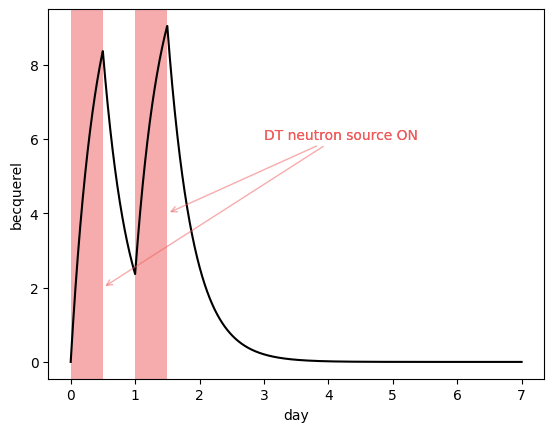

In [4]:
from libra_toolbox.tritium import plotting
import matplotlib.pyplot as plt

plotting.plot_salt_inventory(my_model, color="black")
plotting.plot_irradiation(my_model, facecolor="#EF5B5B", alpha=0.5)


plt.annotate(
    "DT neutron source ON",
    xy=(1.5 * ureg.day, 4 * ureg.Bq),
    xytext=(3 * ureg.days, 6 * ureg.Bq),
    color="#EF5B5B",
    arrowprops=dict(arrowstyle="->", color="#EF5B5B", alpha=0.5),
)
plt.annotate(
    "DT neutron source ON",
    xy=(0.5 * ureg.day, 2 * ureg.Bq),
    xytext=(3 * ureg.days, 6 * ureg.Bq),
    color="#EF5B5B",
    arrowprops=dict(arrowstyle="->", color="#EF5B5B", alpha=0.5),
)

plt.show()

### Release rates

The release rates $Q_i$ are computed and plotted:

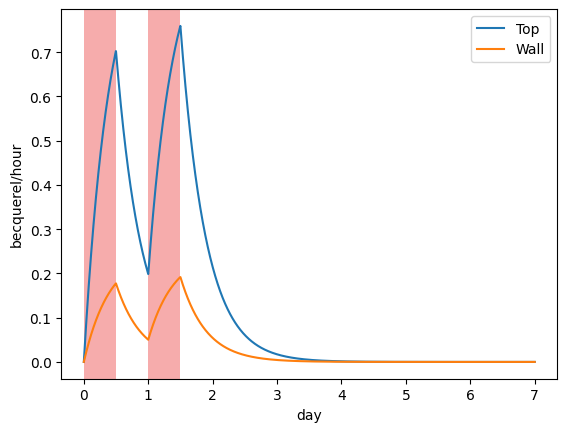

In [5]:
plotting.plot_top_release(my_model, label="Top")
plotting.plot_wall_release(my_model, label="Wall")
plotting.plot_irradiation(my_model, facecolor="#EF5B5B", alpha=0.5)

plt.legend()
plt.show()

### Cumulative releases

It may be interesting to compute the cumulative release because this is what's measured by the bubblers.

$$
\int_0^t Q_i dt
$$

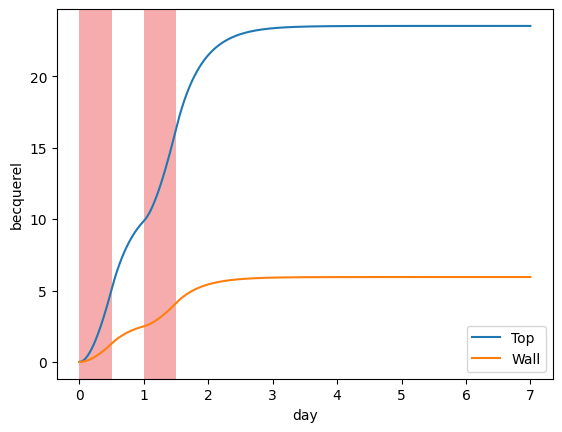

In [6]:
plotting.plot_integrated_top_release(my_model, label="Top")
plotting.plot_integrated_wall_release(my_model, label="Wall")
plotting.plot_irradiation(my_model, facecolor="#EF5B5B", alpha=0.5)

plt.legend()
plt.show()

### LSC sample activity

When sampling, a sample of water is taken from the bubblers and its activity is measured in the Liquid Scintillation Counter.

The activity in the sample therefore depends on the collection volume (the bubbler vial) and the LSC sample volume (ie. how much water from the bubbler is being sampled).

If we assume that all of the water is replaced in the bubblers at each sampling time, then that means the water activity drops to zero.

Using `plot_sample_activity_top` we can try and predict what the sample activity is going to be given a list of sampling times.

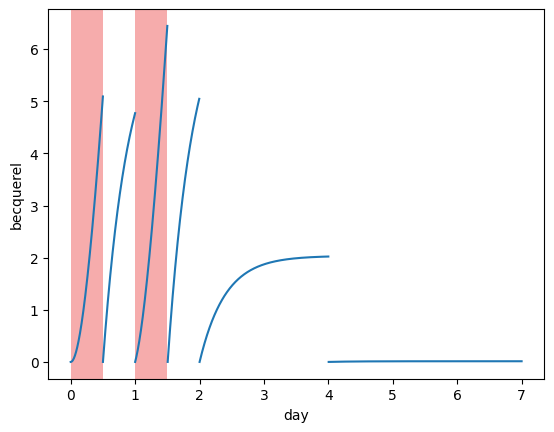

In [7]:
replacement_times = [0.5, 1, 1.5, 2, 4] * ureg.day

plotting.plot_sample_activity_top(my_model, replacement_times=replacement_times)
plotting.plot_irradiation(my_model, facecolor="#EF5B5B", alpha=0.5)
plt.show()

It is also possible to change the default collection volume and sample volume:

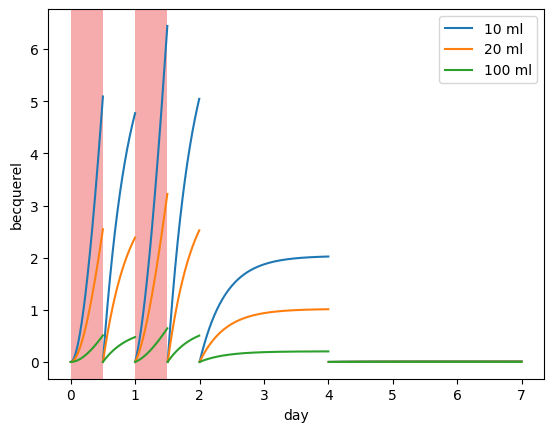

In [8]:
for collection_vol in [10, 20, 100] * ureg.mL:
    plotting.plot_sample_activity_top(
        my_model,
        replacement_times=replacement_times,
        collection_vol=collection_vol,
        label=f"{collection_vol:~.0f}",
    )
plotting.plot_irradiation(my_model, facecolor="#EF5B5B", alpha=0.5)
plt.legend()
plt.show()

The larger the collection volume, the lower the sample activity (for a given sample volume).
It is important to take this into account when designing an experiment and to compare with detectability limits.